<a href="https://colab.research.google.com/github/ArthurFDLR/OpenHand-Models/blob/main/OpenHand-Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤙 OpenHand model design

This Notebook can be used to create Neural Network classifiers running in the [OpenHand application](https://github.com/ArthurFDLR/OpenHand-App).

First, we have to import several libraries to visualize our dataset and create a new model.

In [1]:
# Visualization tools 
from IPython.display import display, HTML, Markdown
from google.colab import widgets

%matplotlib inline
from matplotlib import pylab
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
plt.style.use('ggplot')

# Computation tools 
from pathlib import Path
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.min_rows', 5)

%tensorflow_version 2.x
import tensorflow
from tensorflow import keras

print('Available GPU:')
!nvidia-smi -L
print('\nTensorFlow use GPU at: {}'.format(tensorflow.test.gpu_device_name()))

Available GPU:
GPU 0: Tesla T4 (UUID: GPU-51d5ac3f-2cff-1a5e-cd46-c12b64020977)

TensorFlow use GPU at: /device:GPU:0


## Dataset exploration

While OpenHand already contains a basic dataset, you can easily create and import your own using the application!

In [3]:
dataset_df = pd.read_csv("https://raw.githubusercontent.com/ArthurFDLR/OpenHand-App/master/Dataset/OpenHand_dataset.csv")
labels = dataset_df.label.unique()

display(Markdown("## Complete dataset view"))
display(dataset_df)

display(Markdown("## Number of samples per label and hand"))
df_hand_labels = {hand_i : dataset_df.loc[dataset_df['hand'] == hand_i].groupby('label') for hand_i in ['left', 'right']}
display(
    pd.DataFrame(
        [df.size() for df in df_hand_labels.values()],
        columns=labels,
        index=df_hand_labels.keys(),
        )
)

## Complete dataset view

,label,hand,accuracy,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,x6,y6,x7,y7,x8,y8,x9,y9,x10,y10,x11,y11,x12,y12,x13,y13,x14,y14,x15,y15,x16,y16,x17,y17,x18,y18,x19,y19,x20,y20
0,0,left,15.139381,0.403383,-0.366229,0.194999,-0.361383,-0.013385,-0.264461,-0.149077,-0.162692,-0.216922,-0.060923,0.083538,-0.002769,-0.027923,0.195922,-0.173307,0.094153,-0.207230,0.002077,0.136845,0.036000,-0.042462,0.200768,-0.153923,0.079615,-0.178153,-0.027000,0.199845,0.045692,0.010846,0.195922,-0.095769,0.079615,-0.120000,-0.012462,0.257999,0.040846,0.131999,0.137769,0.015692,0.113538,-0.057000,0.036000
1,0,left,14.065027,0.333266,-0.430984,0.169325,-0.368800,0.016691,-0.255737,-0.152903,-0.142674,-0.226394,-0.040918,0.186284,-0.006999,0.022344,0.106063,-0.113331,0.100410,-0.124638,0.043879,0.231509,0.049532,-0.005922,0.145635,-0.135944,0.094757,-0.203782,0.004307,0.208897,0.038226,0.016691,0.168248,-0.118985,0.111716,-0.147250,0.038226,0.191937,0.004307,0.027997,0.151288,-0.062453,0.128676,-0.113331,0.060838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11202,Ok,right,16.430834,-0.262744,-0.477646,-0.070791,-0.408216,0.100741,-0.355123,0.215096,-0.314281,0.268190,-0.253020,0.031312,-0.085572,0.190592,-0.048815,0.255937,-0.126413,0.255937,-0.244852,-0.038118,-0.020226,0.059900,0.179895,0.137498,0.306502,0.198760,0.408605,-0.132053,-0.024310,-0.111632,0.179895,-0.066707,0.310586,-0.038118,0.412689,-0.213735,-0.065151,-0.262744,0.106381,-0.262744,0.208484,-0.254576,0.310586
11203,Ok,right,15.640315,-0.258065,-0.478518,-0.070381,-0.404227,0.105572,-0.353396,0.211144,-0.318205,0.273705,-0.259554,0.043011,-0.071871,0.203324,-0.040590,0.246334,-0.130522,0.265885,-0.251734,-0.039101,-0.013220,0.058651,0.182284,0.140763,0.303496,0.199414,0.409068,-0.132942,-0.021040,-0.113392,0.182284,-0.074291,0.303496,-0.043011,0.409068,-0.226784,-0.067961,-0.261975,0.107992,-0.265885,0.209654,-0.261975,0.303496


## Number of samples per label and hand

,0,1,2,3,4,5,6,7,8,9,Chef,Help,Super,VIP,Water,Metal,Dislike,Loser,Phone,Shaka,Stop,Spoke,PowerFist,Horns,FightFist,MiddleFinger,Ok
left,207,201,213,203,204,206,208,202,241,221,205,235,203,202,207,208,205,206,201,203,202,205,209,204,204,209,205
right,208,207,203,205,213,206,202,202,205,209,206,209,208,221,204,214,206,205,204,208,204,206,211,207,203,201,208


## Mean sample visualization

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

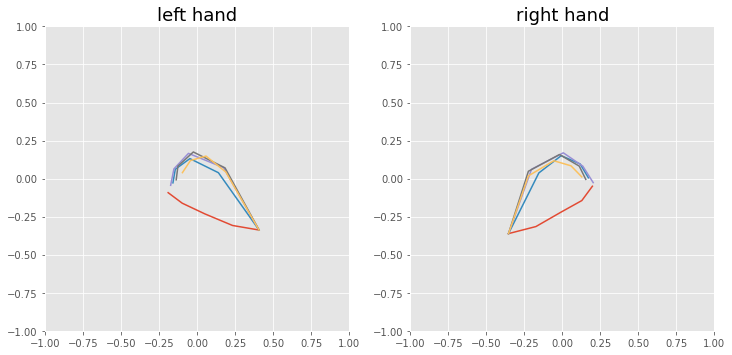

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

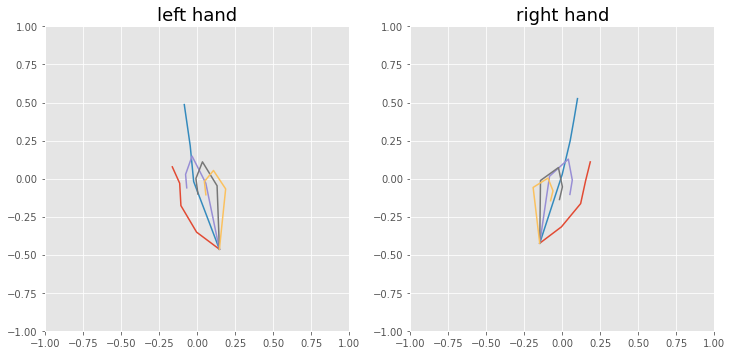

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

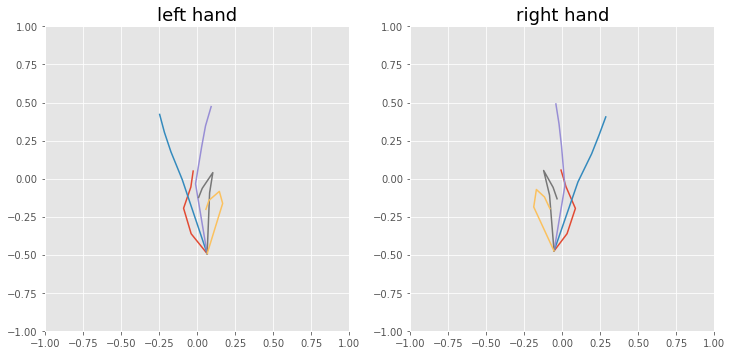

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

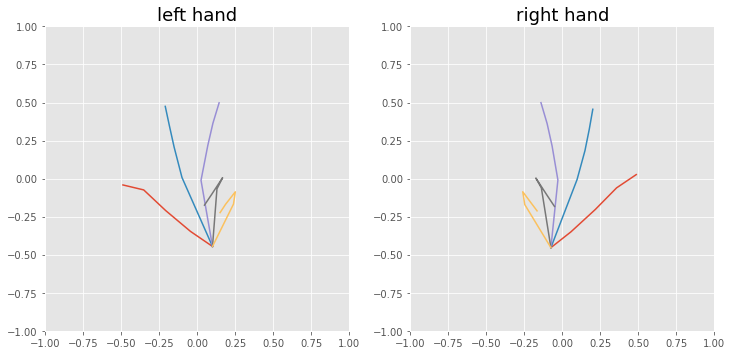

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

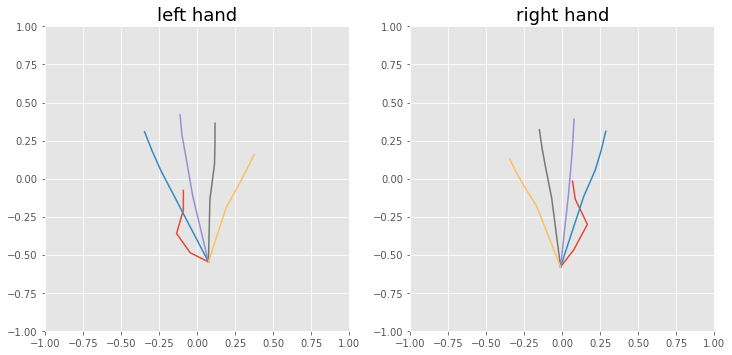

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

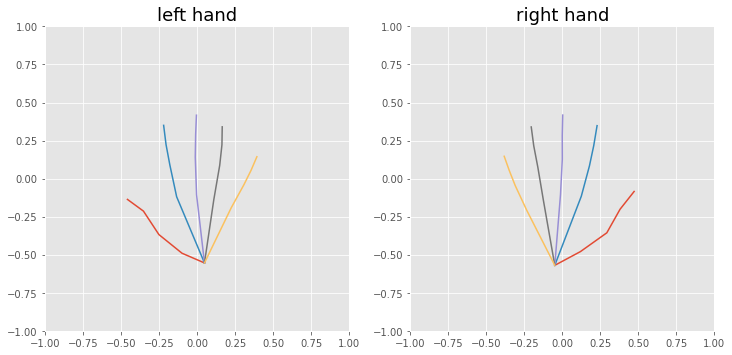

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

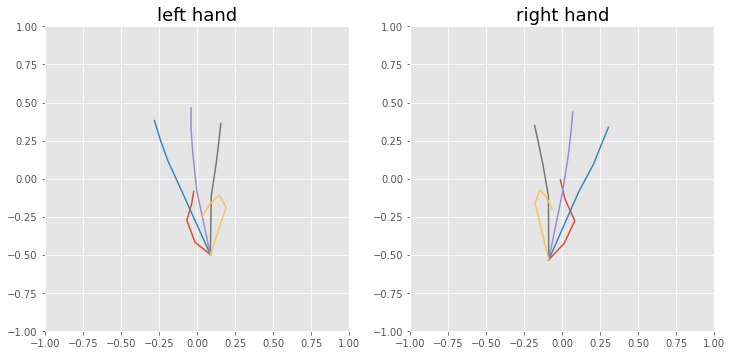

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

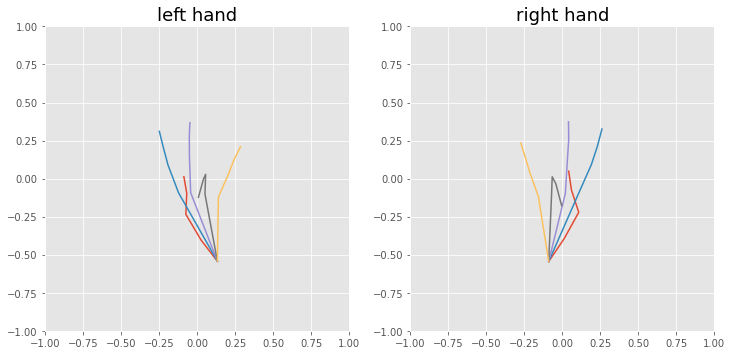

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

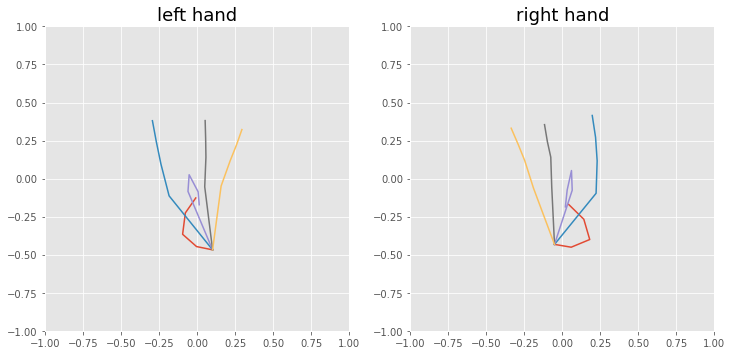

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

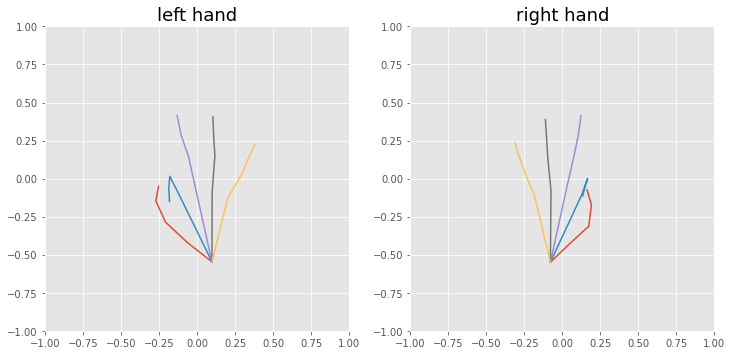

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

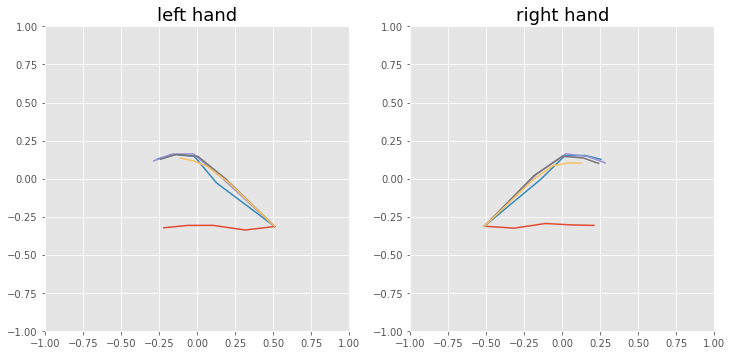

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

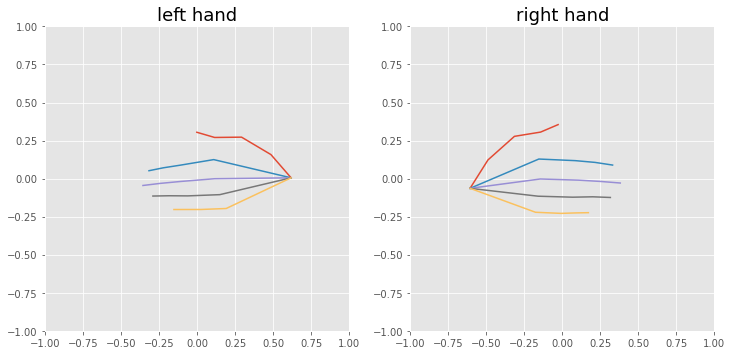

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

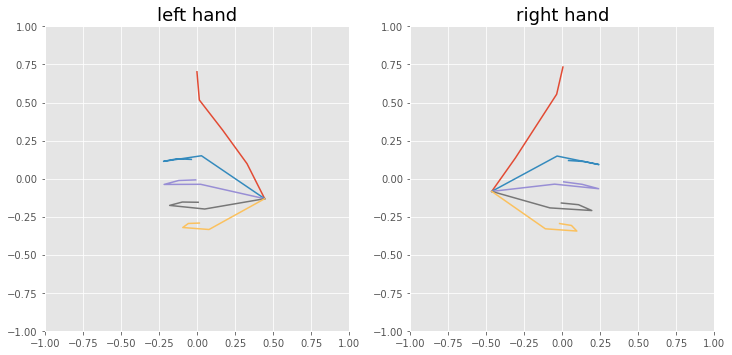

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

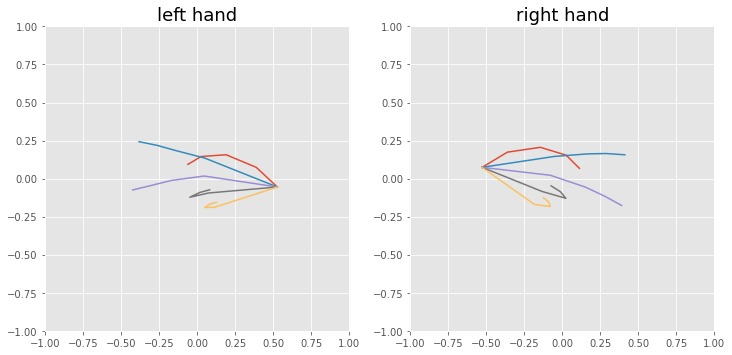

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

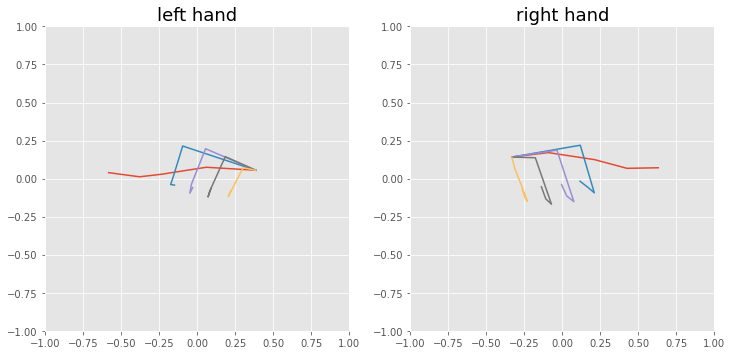

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

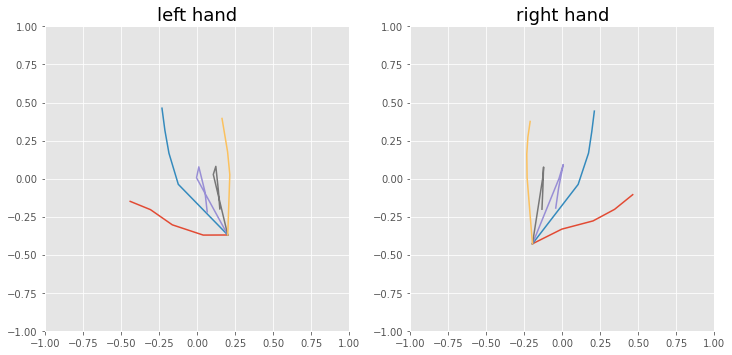

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

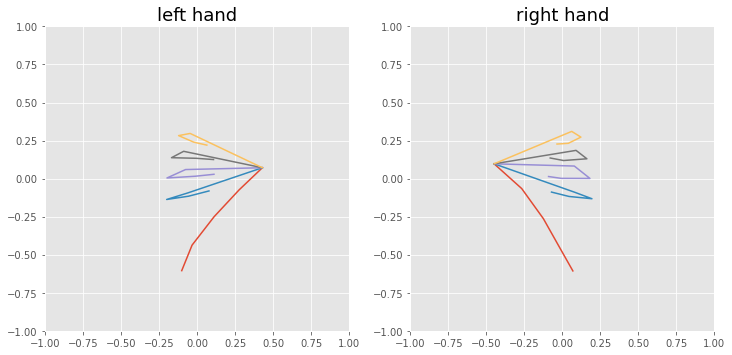

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

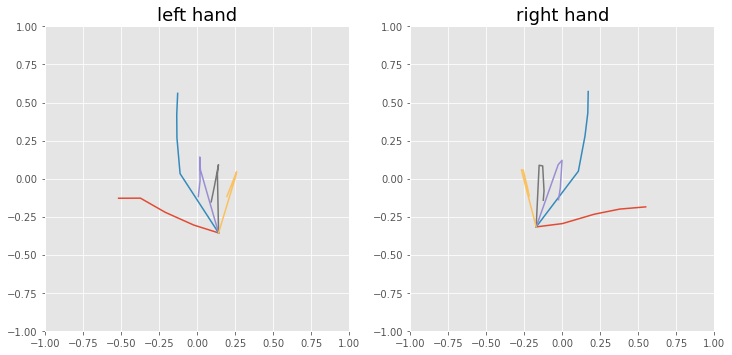

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

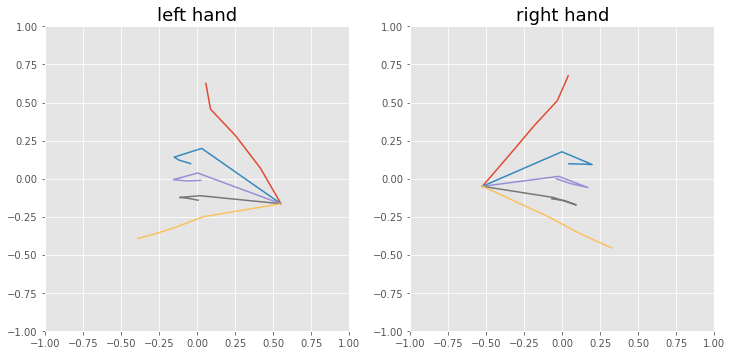

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

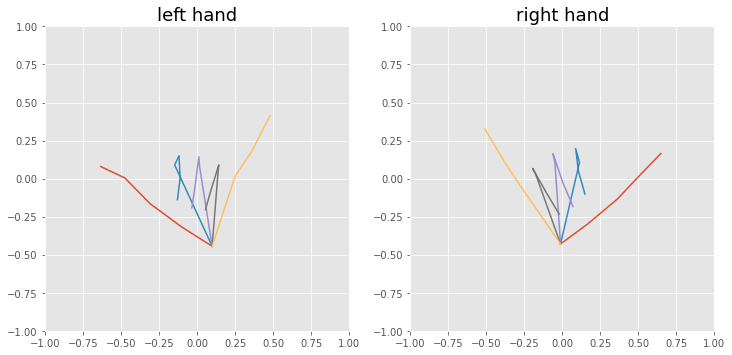

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

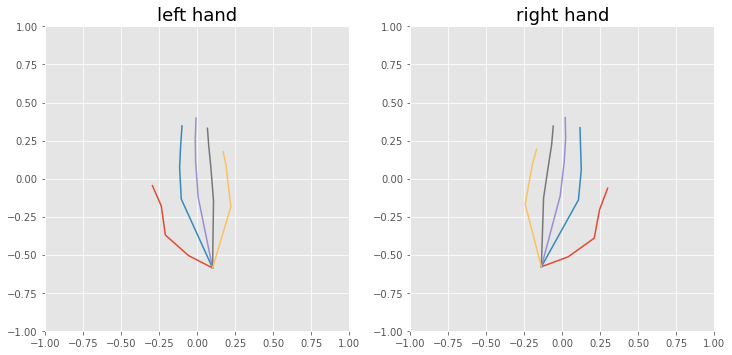

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

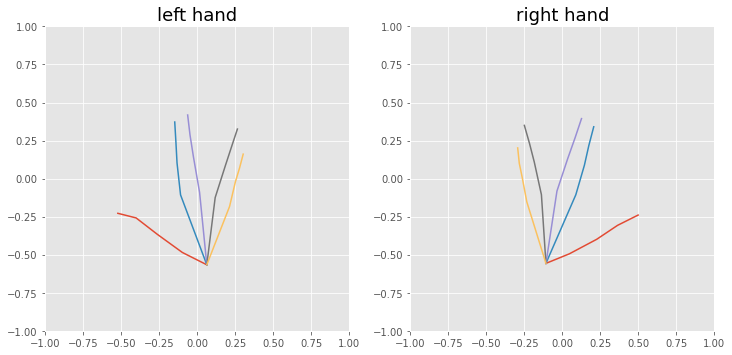

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

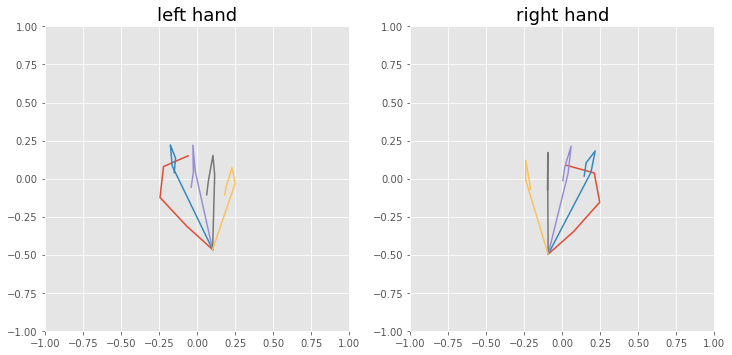

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

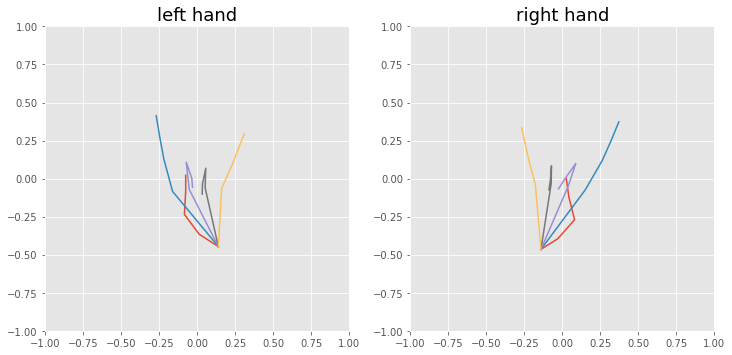

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

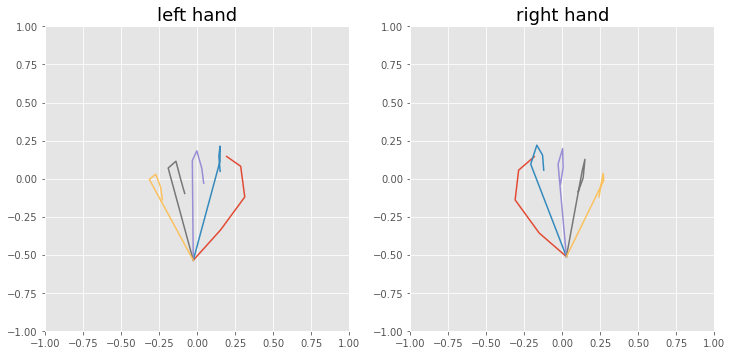

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

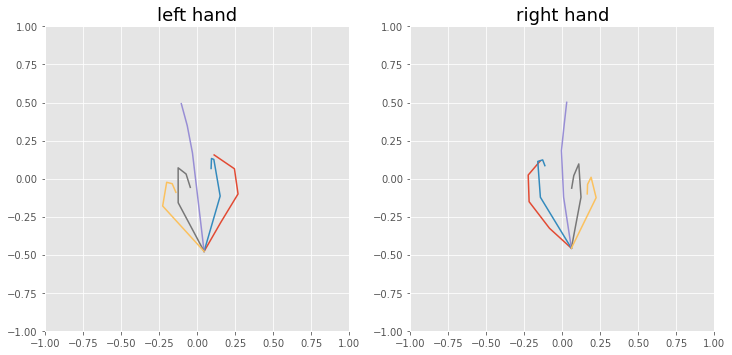

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

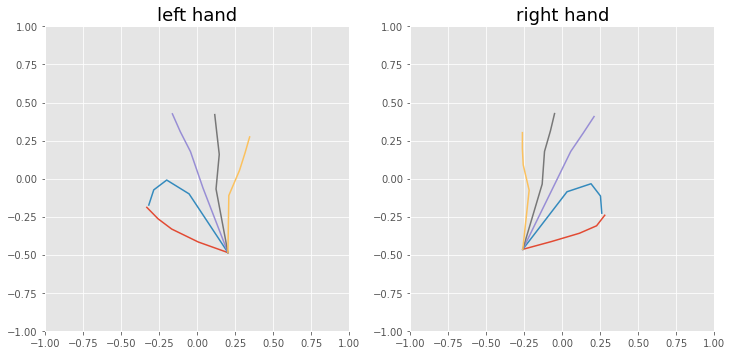

<IPython.core.display.Javascript object>

In [26]:
colors = ["r", "y", "g", "b", "m"]

display(Markdown("## Mean sample visualization"))
tb = widgets.TabBar(list(labels))
for i, label_i in enumerate(labels):
    # Only select the first 3 tabs, and render others in the background.
    with tb.output_to(i, select=(i < 3)):
        fig, axs = pylab.subplots(1, 2, figsize=(12,6))
        for ax, hand_visualization in zip(axs, ['left', 'right']):
            sample_data = dataset_df[(dataset_df.label==label_i) & (dataset_df.hand==hand_visualization)].drop(['label', 'hand', 'accuracy'], axis=1).to_numpy().mean(axis=0)
            sample_data_2D = np.stack([sample_data[::2], sample_data[1::2]])

            sample_fingers = [
                sample_data_2D[:, 0:5],
                np.insert(sample_data_2D[:, 5:9].T, 0, sample_data_2D[:, 0], axis=0).T,
                np.insert(sample_data_2D[:, 9:13].T, 0, sample_data_2D[:, 0], axis=0).T,
                np.insert(sample_data_2D[:, 13:17].T, 0, sample_data_2D[:, 0], axis=0).T,
                np.insert(sample_data_2D[:, 17:21].T, 0, sample_data_2D[:, 0], axis=0).T,
            ]
            for finger, c in zip(sample_fingers, colors):
                ax.plot(finger[0], finger[1])
            ax.set_xlim([-1,1])
            ax.set_ylim([-1,1])
            ax.set_aspect("equal")
            ax.set_title('{} hand'.format(hand_visualization), fontdict={'size':18})
        fig.show()

Now that we know what the dataset looks like, we can create NumPy arrays to train TensorFlow models. We are only using samples associated with the right hand. However, you can easily use the whole dataset to train a single neural network through hands vertical symmetry.

In [5]:
hand_label = 'right'
test_split = 0.15

# Find the minimum number of samples accross categories to uniformly distributed sample sets
total_size_cat = df_hand_labels[hand_label].size().min()
test_size_cat  = int(total_size_cat*test_split)
train_size_cat = total_size_cat - test_size_cat

x_train = []
x_test  = []
y_train = []
y_test  = []

# Iterate over each labeled group
for label, group in df_hand_labels[hand_label]:
    # remove irrelevant columns
    group_array = group.drop(['label', 'hand', 'accuracy'], axis=1).to_numpy()
    np.random.shuffle(group_array)
    
    x_train.append(group_array[:train_size_cat])
    y_train.append([label]*train_size_cat)
    x_test.append(group_array[train_size_cat : train_size_cat+test_size_cat])
    y_test.append([label]*test_size_cat)

# Concatenate sample sets as numpy arrays and shuffle in unison
shuffler_test = np.random.permutation(test_size_cat*len(labels))
shuffler_train = np.random.permutation(train_size_cat*len(labels))
x_train = np.concatenate(x_train, axis=0)[shuffler_train]
x_test = np.concatenate(x_test, axis=0)[shuffler_test]
y_train = np.concatenate(y_train, axis=0)[shuffler_train]
y_test = np.concatenate(y_test, axis=0)[shuffler_test]

# One-hot encoding
y_train_onehot = keras.utils.to_categorical([list(labels).index(sample) for sample in y_train])
y_test_onehot  = keras.utils.to_categorical([list(labels).index(sample) for sample in y_test])

display(HTML('''There are {n_cat} categories with a minimum of {min} samples for the {hand} hand,
                Given a training/test split ratio of {split}% on uniformly distributed sets,
                the training set has {n_train} samples and the test set has {n_test} samples:'''
             .format(hand=hand_label, n_cat=len(labels), min=total_size_cat, split=test_split*100, n_train=x_train.shape[0], n_test=x_test.shape[0])))
display(pd.DataFrame([str(d.shape) for d in (x_train, x_test, y_train, y_test, y_train_onehot, y_test_onehot)],
                     index = ['x_train', 'x_test', 'y_train', 'y_test', 'y_train_onehot', 'y_test_onehot'],
                     columns = ['shape']))

,shape
x_train,"(4617, 42)"
x_test,"(810, 42)"
y_train,"(4617,)"
y_test,"(810,)"
y_train_onehot,"(4617, 27)"
y_test_onehot,"(810, 27)"


## Models exploration

This section is optional. The following blocks can be used to compare different model architecture and training processes.

In [6]:
model_train_history = {}
input_dim = x_train.shape[1]
validation_split = 0.20
epochs = 15

In [7]:
model = keras.models.Sequential(name = 'ANN-3x16',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(16, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=0,
)

Model: "ANN-3x16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                688       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 27)                459       
Total params: 1,691
Trainable params: 1,691
Non-trainable params: 0
_________________________________________________________________


In [8]:
model = keras.models.Sequential(name = 'ANN-3x64',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=0,
)

Model: "ANN-3x64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2752      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 27)                1755      
Total params: 12,827
Trainable params: 12,827
Non-trainable params: 0
_________________________________________________________________


In [9]:
model = keras.models.Sequential(name = 'ANN-3x64-Dropouts',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=0,
)

Model: "ANN-3x64-Dropouts"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                2752      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 27)          

In [10]:
model = keras.models.Sequential(name = 'ANN-2x128',
                                   layers =
    [
        keras.layers.Input(shape=input_dim),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(128, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model_train_history[model] = model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=epochs,
    batch_size=4,
    validation_split=validation_split,
    shuffle=True,
    verbose=0,
)

Model: "ANN-2x128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               5504      
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 27)                3483      
Total params: 25,499
Trainable params: 25,499
Non-trainable params: 0
_________________________________________________________________


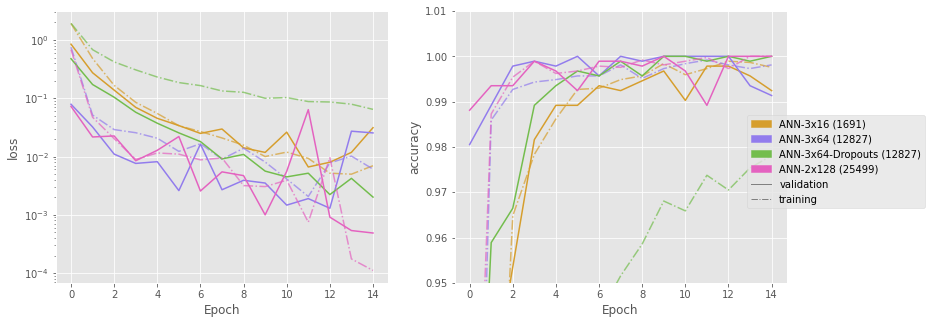

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(14,5))
colors_graph = ["#d69e2d",
                "#927ced",
                "#73bd4d",
                "#e462c0",
                "#eb5e52"]
handles = []

for (model, history), color in zip(model_train_history.items(), colors_graph):
    label = '{} ({})'.format(model.name, model.count_params())
    axs[0].plot(history.history['loss'], c=color, ls='-.', alpha=.7)
    axs[1].plot(history.history['accuracy'], c=color, ls='-.', alpha=.7)
    axs[0].plot(history.history['val_loss'], c=color)
    axs[1].plot(history.history['val_accuracy'], c=color)
    handles.append(mpatches.Patch(color=color, label=label))

for ax in axs:
    ax.set_xlabel('Epoch')
axs[0].set_ylabel('loss')
axs[0].set_yscale('log')
axs[1].set_ylabel('accuracy')
axs[1].set_ylim(0.95,1.01)

handles.append(Line2D([0], [0], color='grey', lw=1, ls='-', label='validation'))
handles.append(Line2D([0], [0], color='grey', lw=1, ls='-.', label='training'))

fig.subplots_adjust(right=0.85)
fig.legend(handles=handles,
           loc="center right",
           borderaxespad=1)

## Model export

Once you have a good model, you can save it on your Google Drive. The model is saved using the [folder hierarchy of OpenHand](https://github.com/ArthurFDLR/OpenHand-App#pose-classifier-models).

In [2]:
from google.colab import drive
from pathlib import Path

content_path = Path('/').absolute() / 'content'
drive_path = content_path / 'drive'
drive.mount(str(drive_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
model = keras.models.Sequential(name = '27Class_3x64',
                                   layers =
    [
        keras.layers.Input(shape=x_train.shape[1]),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(64, activation=keras.activations.relu),
        keras.layers.Dense(len(labels), activation=keras.activations.softmax),
    ]
)

model.summary()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

save_path = drive_path / 'My Drive'
for subfolder in ['OpenHand', 'Models', model.name]:
    save_path /= subfolder
    if not (save_path).is_dir():
        %mkdir "{save_path}"
    

model_path = save_path / '{name}_{hand}.h5'.format(name = model.name, hand = hand_label)

model.fit(
    x=x_train,
    y=y_train_onehot,
    epochs=10,
    batch_size=4,
    validation_split=0.15,
    shuffle=True,
    callbacks=[keras.callbacks.ModelCheckpoint(filepath=model_path, verbose=1, save_best_only=True)],
    verbose = 2,
)

class_file = open(save_path / 'class.txt', 'w')
for i, label_i in enumerate(labels):
    class_file.write((',' if i!=0 else '') + label_i)
class_file.close()

Model: "27Class_3x64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                2752      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_18 (Dense)             (None, 27)                1755      
Total params: 12,827
Trainable params: 12,827
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
981/981 - 2s - loss: 0.7942 - accuracy: 0.7867 - val_loss: 0.1111 - val_accuracy: 0.9582

Epoch 00001: val_loss improved from inf to 0.11109, saving model to /content/drive/My Drive/OpenHand/Models/27Class_3x64/27Class_3x64_right.h5
Epoc

In [13]:
model_test = keras.models.load_model(model_path)
model_test.evaluate(x=x_test, y=y_test_onehot)

26/26 [==============================] - 0s 2ms/step - loss: 0.0018 - accuracy: 1.0000


[0.0018195720622316003, 1.0]